# **Meflah wided _22214601**

# Notebook reconnaissance Elephant (partie 1)

Dans ce notebook, nous allons mettre en place un modèle baseline et un modèle amilioré pout identifier les éléphants.

In [ ]:
# Importation des différentes librairies utiles pour le notebook

#Sickit learn met régulièrement à jour des versions et
#indique des futurs warnings.
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# librairies générales
import pickle
import pandas as pd
from scipy.stats import randint
import numpy as np
import string
import time
import base64
import re
import sys
import copy
import random
from numpy import mean
from numpy import std


# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import plotly.graph_objs as go
import plotly.offline as py

from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# TensorFlow et keras
import tensorflow as tf
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
from tqdm import tqdm
from keras.models import load_model
from sklearn.model_selection import KFold
from keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Activation

from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD, Adam
import os
from os import listdir
from os.path import isfile, join
import cv2
import glob

In [ ]:
def plot_curves_confusion (history,confusion_matrix,class_names):
  plt.figure(1,figsize=(16,6))
  plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1,
                          top = 0.9, wspace = 0.25, hspace = 0)

  # division de la fenêtre graphique en 1 ligne, 3 colonnes,
  # graphique en position 1 - loss fonction

  plt.subplot(1,3,1)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['Training loss', 'Validation loss'], loc='upper left')
  # graphique en position 2 - accuracy
  plt.subplot(1,3,2)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')

  # matrice de correlation
  plt.subplot(1,3,3)
  sns.heatmap(conf,annot=True,fmt="d",cmap='Blues',xticklabels=class_names, yticklabels=class_names)# label=class_names)
  # labels, title and ticks
  plt.xlabel('Predicted', fontsize=12)
  #plt.set_label_position('top')
  #plt.set_ticklabels(class_names, fontsize = 8)
  #plt.tick_top()
  plt.title("Correlation matrix")
  plt.ylabel('True', fontsize=12)
  #plt.set_ticklabels(class_names, fontsize = 8)
  plt.show()


def plot_curves(histories):
    plt.figure(1,figsize=(16,6))
    plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1,
                          top = 0.9, wspace = 0.25, hspace = 0)

    for i in range(len(histories)):
    	# plot loss
    	plt.subplot(121)
    	plt.title('Cross Entropy Loss')
    	plt.plot(histories[i].history['loss'], color='blue', label='train')
    	plt.plot(histories[i].history['val_loss'], color='red', label='test')
    	plt.ylabel('loss')
    	#plt.ylim([0, 1])
    	plt.xlabel('epoch')
    	plt.legend(['Training loss', 'Validation loss'], loc='upper left')
    	# plot accuracy
    	plt.subplot(122)
    	plt.title('Classification Accuracy')
    	plt.ylabel('accuracy')
    	#plt.ylim([0, 1])
    	plt.xlabel('epoch')
    	plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    	plt.plot(histories[i].history['val_accuracy'], color='red',
                 label='test')
    	plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
    plt.show()

Enregistrement google drive


In [ ]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import sys
my_local_drive='/content/gdrive/MyDrive/ML2_prjt2023'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

/content/gdrive/MyDrive/ML2_prjt2023


'/content/gdrive/MyDrive/ML2_prjt2023'

# Jeux de données

Récupération des données

In [ ]:
#!wget https://www.lirmm.fr/~poncelet/Ressources/Tiger-Fox-Elephant.zip

In [ ]:
"""
import zipfile
with zipfile.ZipFile("Tiger-Fox-Elephant.zip","r") as zip_ref:
    zip_ref.extractall("Data_Project")
    """

'\nimport zipfile\nwith zipfile.ZipFile("Tiger-Fox-Elephant.zip","r") as zip_ref:\n    zip_ref.extractall("Data_Project")\n    '

Visualisation de quelques images du jeu dedonnées

In [ ]:

IMG_SIZE=124
COLUMNS = 25 # Nombre d'images à afficher

mypath='Data_Project/Tiger-Fox-Elephant/elephant'
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
images = np.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  images[n] = cv2.imread( join(mypath,onlyfiles[n]) )
  images[n]  = cv2.resize(images[n], (IMG_SIZE, IMG_SIZE))

plt.figure(figsize=(15,15))
for i in range(COLUMNS):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # cv2 lit met les images en BGR et matplotlib lit du RGB
    # il faut donc convertir pour afficher les bonnes couleurs
    images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
    plt.imshow(images[i],cmap=plt.cm.binary)
    plt.xlabel('taille ' + str(images[i].shape))

Output hidden; open in https://colab.research.google.com to view.

#Création du jeu de données

## fonctions utliles

In [ ]:
# constantes globales

IMG_SIZE=124
COLUMNS = 25 # Nombre d'images à afficher

In [ ]:
def create_training_data(path_data, list_classes):
  training_data=[]
  for classes in list_classes:
      path=os.path.join(path_data, classes)
      class_num=list_classes.index(classes)
      for img in os.listdir(path):
        try:
          img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_UNCHANGED)
          new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
          training_data.append([new_array, class_num])
        except Exception as e:
          pass
  return training_data

def create_X_y (path_data, list_classes):
      # récupération des données
      training_data=create_training_data(path_data, list_classes)
      # tri des données
      random.shuffle(training_data)
      # création de X et y
      X=[]
      y=[]
      for features, label in training_data:
        X.append(features)
        y.append(label)
      X=np.array(X).reshape(-1,IMG_SIZE, IMG_SIZE, 3)

      y=np.array(y)
      return X,y

def plot_examples(X,y):
  plt.figure(figsize=(15,15))
  for i in range(COLUMNS):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #plt.colorbar()

    # cv2 lit met les images en BGR et matplotlib lit du RGB
    X[i] = cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB)

   # plt.imshow((X[i]/255.).squeeze(),cmap=plt.cm.binary)
    plt.imshow((X[i]/255.),cmap=plt.cm.binary)

    plt.xlabel('classe ' + str(y[i]))


## Visualisation du jeu d'apprentissage

In [ ]:
my_path="Data_Project/Tiger-Fox-Elephant/"
my_classes=['elephant','Elephant_negative_class']
X,y=create_X_y (my_path,my_classes)
print ("Nombre de données : ",X.shape)
print ("Taille d'une image pour connaître l'input du réseau", X[0].shape)
print ("Distribution des labels dans le jeu d'apprentissage")
sns.countplot(np.array(y))
plt.title("Nombre d'éléments par classe")
# affichage
plot_examples(X,y)

# Surtout ne pas oublier de normaliser les données avec :
X=X.astype('float')
X=X/255.0

Output hidden; open in https://colab.research.google.com to view.

## Fonctions pour mettre en place l'apprentissage

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def load_dataset():
		# Chargement des données
		my_path="Data_Project/Tiger-Fox-Elephant/"
		my_classes=['elephant','Elephant_negative_class']
		X,y=create_X_y (my_path,my_classes)
		X_train,X_test , y_train, y_test  = train_test_split(X,y)
		# ne considérer qu'un seul canal
		# one hot encoding
		y_train = to_categorical(y_train)
		y_test = to_categorical(y_test)
		return X_train, y_train, X_test, y_test


def clean_data(train, test):
	# convertion d'entier en float
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalisation entre 0 et 1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	return train_norm, test_norm

# ModeleBaseElephant


In [ ]:

def evaluate_model(dataX, dataY, n_folds=5, epochs=10):
  scores, histories = list(), list()
  kfold = KFold(n_folds, shuffle=True, random_state=1)

  for train_ix, test_ix in kfold.split(dataX):
    model = define_model()

    print(model.summary())

    X_train, y_train, X_test, y_test = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

    batch_size = 64



    history = model.fit(X_train, y_train,
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test), verbose=1)

    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print('accuracy %.3f' % (acc * 100.0))
    scores.append(acc)
    histories.append(history)
  return scores, histories



def define_model():
    model = Sequential()

    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(124, 124, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Flatten())

    model.add(Dense(2, activation='sigmoid'))

    opt = Adam()
    model.compile(optimizer=opt, loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

def run_evaluation(n_folds,epochs):

	X_train, y_train, X_test, y_test = load_dataset()

	X_train, X_test = clean_data(X_train, X_test)
	scores, histories = evaluate_model(X_train, y_train, n_folds,epochs)
	plot_curves(histories)
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 61, 61, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 119072)            0         
                                                                 
 dense_1 (Dense)             (None, 2)                 238146    
                                                                 
Total params: 239042 (933.76 KB)
Trainable params: 239042 (933.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100
1/1 [==============================] - 10s 10s/step - loss: 0.7

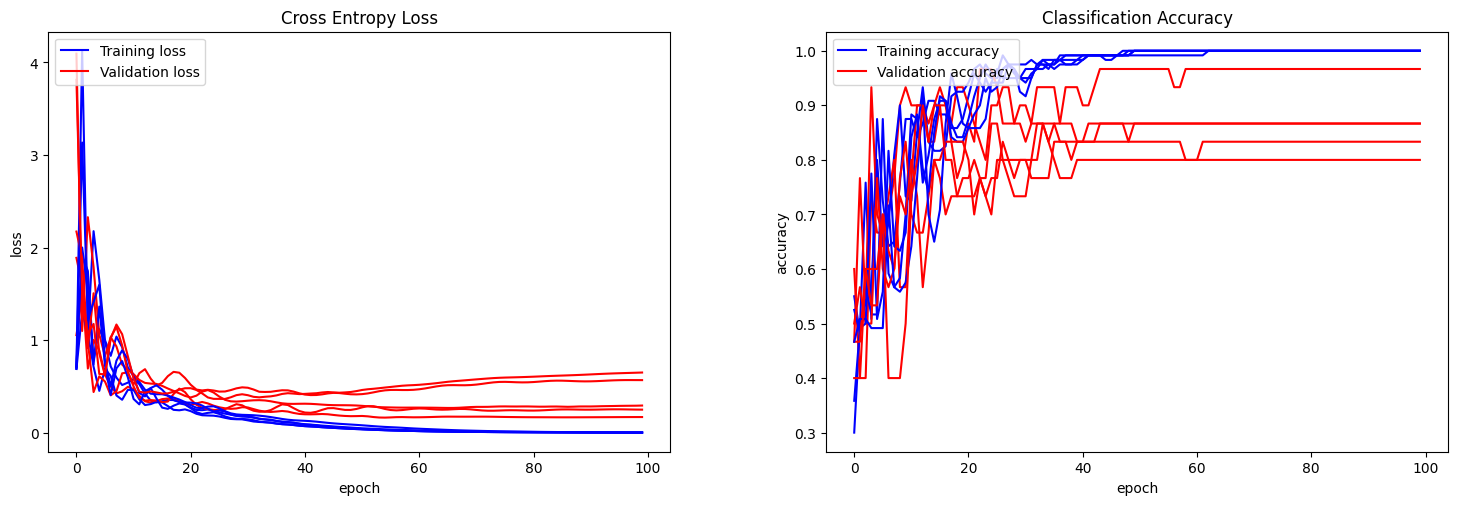

Accuracy: mean=86.667 std=5.578, n=5


In [ ]:
n_folds=5
epochs=100
run_evaluation(n_folds,epochs)

# Modele-Elephant (Amilioré)

In [ ]:

def evaluate_model(dataX, dataY, n_folds=5, epochs=10):
  scores, histories = list(), list()
  kfold = KFold(n_folds, shuffle=True, random_state=1)

  for train_ix, test_ix in kfold.split(dataX):
    model-elephant = define_model_amilore()

    print( model-elephant.summary())

    X_train, y_train, X_test, y_test = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

    batch_size = 64




    history =  model-elephant.fit(X_train, y_train,
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test), verbose=1)

    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print('accuracy %.3f' % (acc * 100.0))
    scores.append(acc)
    histories.append(history)
  return scores, histories



def define_model_amilore(learning_rate=0.001):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(124, 124, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model


def run_evaluation(n_folds,epochs):

	X_train, y_train, X_test, y_test = load_dataset()

	X_train, X_test = clean_data(X_train, X_test)
	scores, histories = evaluate_model(X_train, y_train, n_folds,epochs)
	plot_curves(histories)
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 122, 122, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 61, 61, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 29, 29, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 53824)             0         
                                                                 
 dropout (Dropout)           (None, 53824)             0

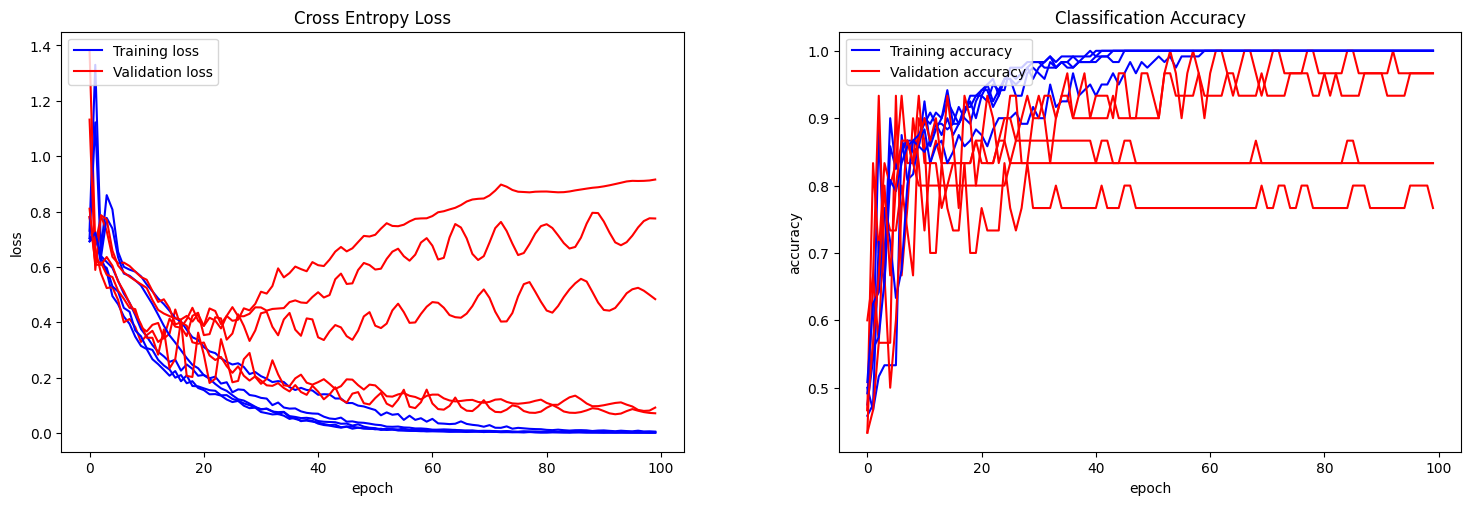

Accuracy: mean=87.333 std=8.000, n=5


In [ ]:
n_folds=5
epochs=100
run_evaluation(n_folds,epochs)